# Lens modeling of DESIJ1537+1443 with `lenstronomy`

Author(s): Md. Mehedi Hasan, Anowar J. Shajib \
Acknowledgement: Sulyman Hossain

In [22]:
import corner
import h5py
import joblib
import lenstronomy.Util.param_util as param_util
import matplotlib.pyplot as plt
import numpy as np
import yaml
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

In [3]:
with h5py.File("DESIJ1537+1443_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data["image_data"]


with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"

C:\Users\HTCM\AppData\Local\Temp\ipykernel_3380\2739470995.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");


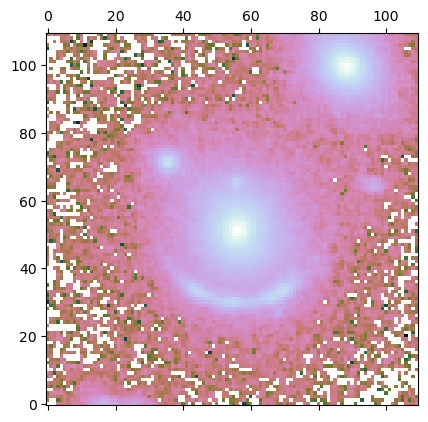

In [4]:
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");

## **A brief overview of lens modeling for DESIJ1537+1443:**
<p>We interpreted the arc spanning from roughly 4 o'clock to approximately 8:30 o'clock as the primary gravitational lensing structure, accompanied by a smaller blob positioned around 12 o'clock, which acted as its corresponding counter image. We employed masking to obscure elements in the image that were not related to gravitational lensing.</p>
<p>The modeling was started with the following lens, source and lens-light profiles:
    
    lens_model_list = ["EPL", "SHEAR"]
    source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
    lens_light_model_list = ["SERSIC_ELLIPSE"]

and the constraints:
    
    joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]
    joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]
</p>
<p>The reduced chi-squared value converged at around 1.05 at first. We made the choice to avoid applying constraints and opted to fit the model with maximum flexibility.

Therefore, we eliminated the constraints and, in the new model, the Particle Swarm Optimization (PSO) yielded a value of approximately 0.98. However, there were some small yet persistent residuals at the 12 o'clock position. Consequently, we opted to keep the parameter <mark>**gamma**</mark> fixed for PSO during the fitting_sequence, allowing it to remain flexible for Markov Chain Monte Carlo (MCMC) optimization. With this adjustment, the MCMC chain exhibited a smooth convergence, and the updated model achieved a PSO value of around 0.94 and an MCMC value of approximately 0.90.</p>
But the ellipticity difference of light and mass profile was quite big(more than 0.3). So, finally we decided to add a custom log likelihood function for both and eventually ran PSO and MCMC again.

## Likelihood mask:

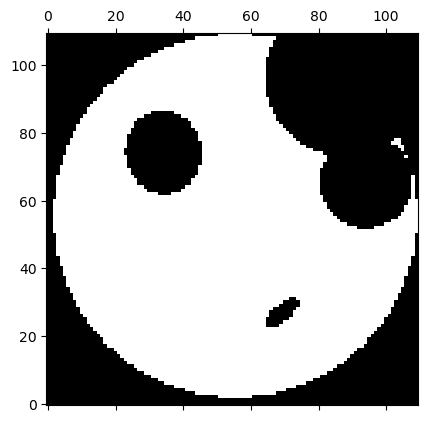

C:\Users\HTCM\AppData\Local\Temp\ipykernel_3380\1017133317.py:85: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
C:\Users\HTCM\AppData\Local\Temp\ipykernel_3380\1017133317.py:85: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


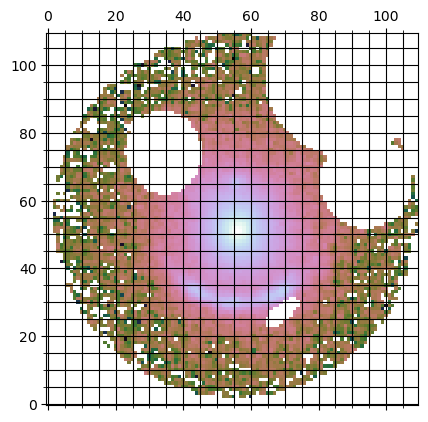

In [5]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)


r = 4.3  # In Arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra + 0,
    lens_center_dec + 0,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.6,
    lens_center_dec + 3.3,
    1.9,
    1.9,
    6,
)


mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.1,
    lens_center_dec + 0.8,
    1.1,
    1.1,
    6,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.7,
    lens_center_dec + 1.5,
    0.9,
    1,
    3,
)

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.1,
    lens_center_dec - 2.3,
    0.2,
    0.5,
    4,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# Masking Image Data
masked_image_data = np.multiply(image_data, mask)
plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

In [6]:
transform_pix2angle

array([[-8.00000000e-02, -3.55387744e-20],
       [ 3.13677657e-20,  8.00000000e-02]])

In [7]:
lens_model_list = ["EPL", "SHEAR"]

source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]

lens_light_model_list = ["SERSIC_ELLIPSE"]

In [8]:
# Lens Galaxy's Mass Model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append(
    {
        "theta_E": 1.550047423883234,
        "gamma": 2,  # 2
        "e1": -0.04281879595631943,
        "e2": 0.06205521348259089,
        "center_x": 0.005302508331193216,
        "center_y": 0.219170896924636,
    }
)


kwargs_lens_init.append({"gamma1": 0.03703012320165664, "gamma2": 0.006104718254838465})


kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)

kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1})

kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -20,
        "center_y": -20,
    }
)

kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})  # 0.3

kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 20,
        "center_y": 20,
    }
)

kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# Lens Galaxy's Light Model

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 4.0})


kwargs_lens_light_init.append(
    {
        "R_sersic": 0.6781768319945262,
        "e1": -0.05774850214782343,
        "e2": 0.024799056682792302,
        "center_x": -0.06728554184774112,
        "center_y": -0.34153509619658057,
        "amp": 78.12337304510329,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)


kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 3,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# Source Galaxy's Light Model

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({"n_sersic": 1.0})
fixed_source.append({"n_max": 8})

kwargs_source_init.append(
    {
        "R_sersic": 0.15790284143613165,
        "n_sersic": 1.0,
        "e1": 0.1199268324811682,
        "e2": 0.0055540488774888375,
        "center_x": -0.1119379310057376,
        "center_y": -0.24960683153328672,
        "amp": 29.614569554179482,
    }
)

kwargs_source_init.append(
    {
        "beta": 0.07693568584687635,
        "center_x": -0.1119379310057376,
        "center_y": -0.24960683153328672,
    }
)


kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.01,
        "e1": 0.08,
        "e2": 0.07,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_source_sigma.append({"beta": 0.05, "center_x": 0.2, "center_y": 0.2})


kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.04,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_lower_source.append({"beta": 0.01, "center_x": -5, "center_y": -5})

kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

kwargs_upper_source.append({"beta": 0.2, "center_x": 5, "center_y": 5})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# Combining Everything in `kwargs_params` Dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}


kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
}

In [9]:
def custom_log_likelihood_addition(
    kwargs_lens=None,
    kwargs_source=None,
    kwargs_lens_light=None,
    kwargs_ps=None,
    kwargs_special=None,
    kwargs_extinction=None,
):
    """

    :param kwargs_lens: lens mass model keywords

    :type kwargs_lens: list

    :param kwargs_source: source light model keywords

    :type kwargs_source: list

    :param kwargs_lens_light: lens light model keywords

    :type kwargs_lens_light:  list

    :param kwargs_ps: point source keywords

    :type kwargs_ps: list

    :param kwargs_special: special keywords

    :type kwargs_special: list

    :param kwargs_extinction: extinction model keywords

    :type kwargs_extinction: list

    :return: custom log_likelihood

    :rtype: float

    """

    log_likelihood = 0.0

    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]["e1"], kwargs_lens[0]["e2"])

    # Initial effective ellipticity of the lens light profiles after PSO is:
    light_q = 0.87752

    gaussian_std = 0.01
    if mass_q < light_q:
        log_likelihood += -0.5 * (mass_q - light_q) ** 2 / gaussian_std**2

    return log_likelihood

In [10]:
kwargs_likelihood = {
    "custom_logL_addition": custom_log_likelihood_addition,
    "check_bounds": True,
    "image_likelihood_mask_list": [mask],
}


kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

In [11]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}


multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]


kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## Fitting the PSO sequence

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)


fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 250}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-0.9290681901729222 reduced X^2 of best position
-3318.631575297678 log likelihood
7144 effective number of data points
[{'theta_E': 1.5217772152251594, 'gamma': 2, 'e1': -0.07075222243538762, 'e2': 0.025879145615291192, 'center_x': -0.033244944003938445, 'center_y': 0.4356283245304627}, {'gamma1': 0.07825058289666453, 'gamma2': -0.006181185905329882, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.19946554208599757, 'n_sersic': 1.0, 'e1': 0.17289171377711698, 'e2': -0.09959472352385644, 'center_x': -0.05697730405367622, 'center_y': -0.47195864859307646}, {'amp': 1, 'n_max': 8, 'beta': 0.10601008675685672, 'center_x': -0.05697730405367622, 'center_y': -0.47195864859307646}] source result
[{'amp': 1, 'R_sersic': 0.721753008793741, 'n_sersic': 4.0, 'e1': -0.05851496588992164, 'e2': 0.028178958872689282, 'center_x': -0.067818160397

In [ ]:
result_mass_e1 = kwargs_result["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.8598827124274087,
light_q: 0.8780285182711888


## Saving the resulting joblib file:

In [ ]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ1537+1443_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualization for the PSO fits:

-0.9202597324824765 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9202597324824772


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


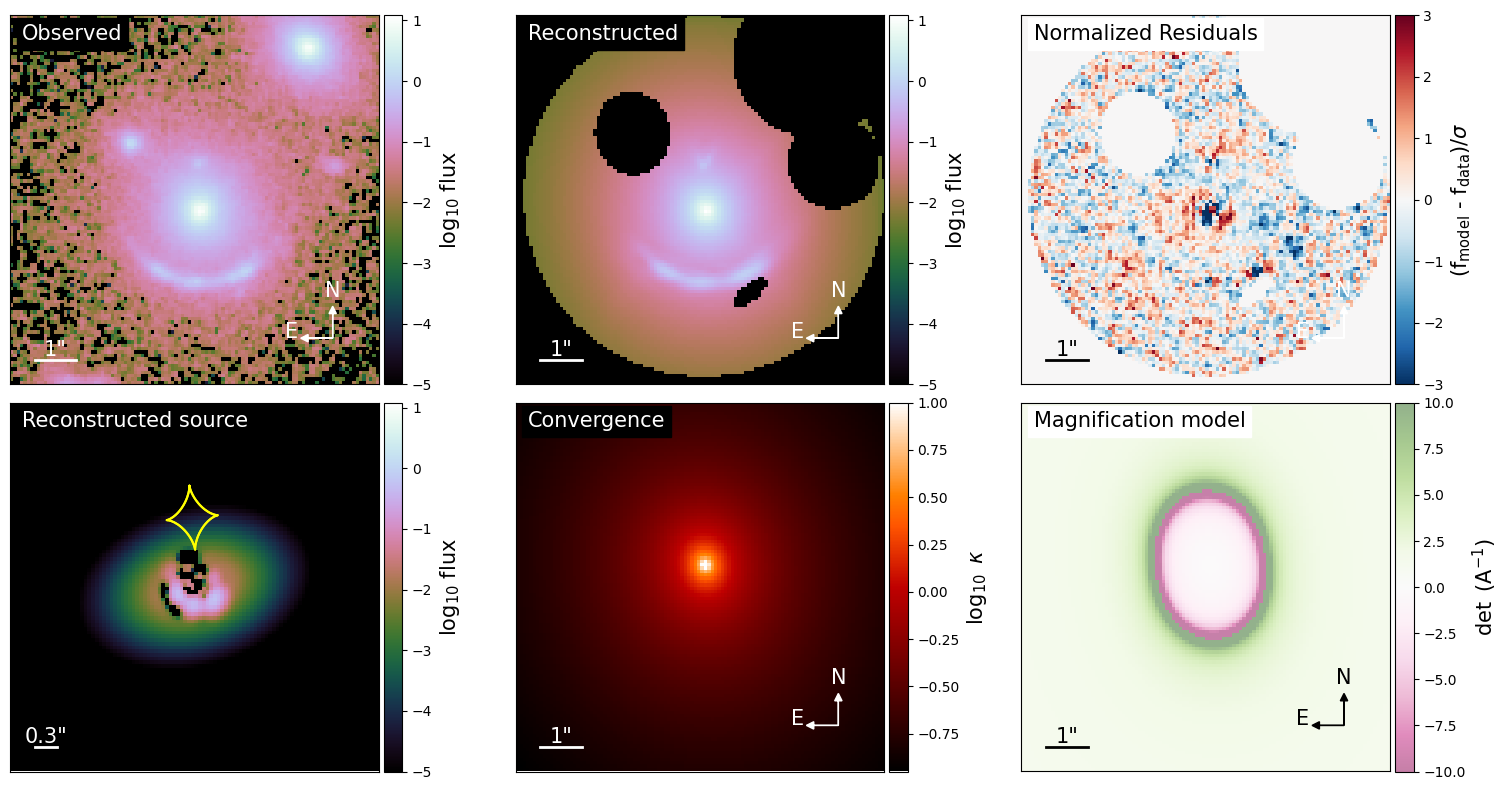

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


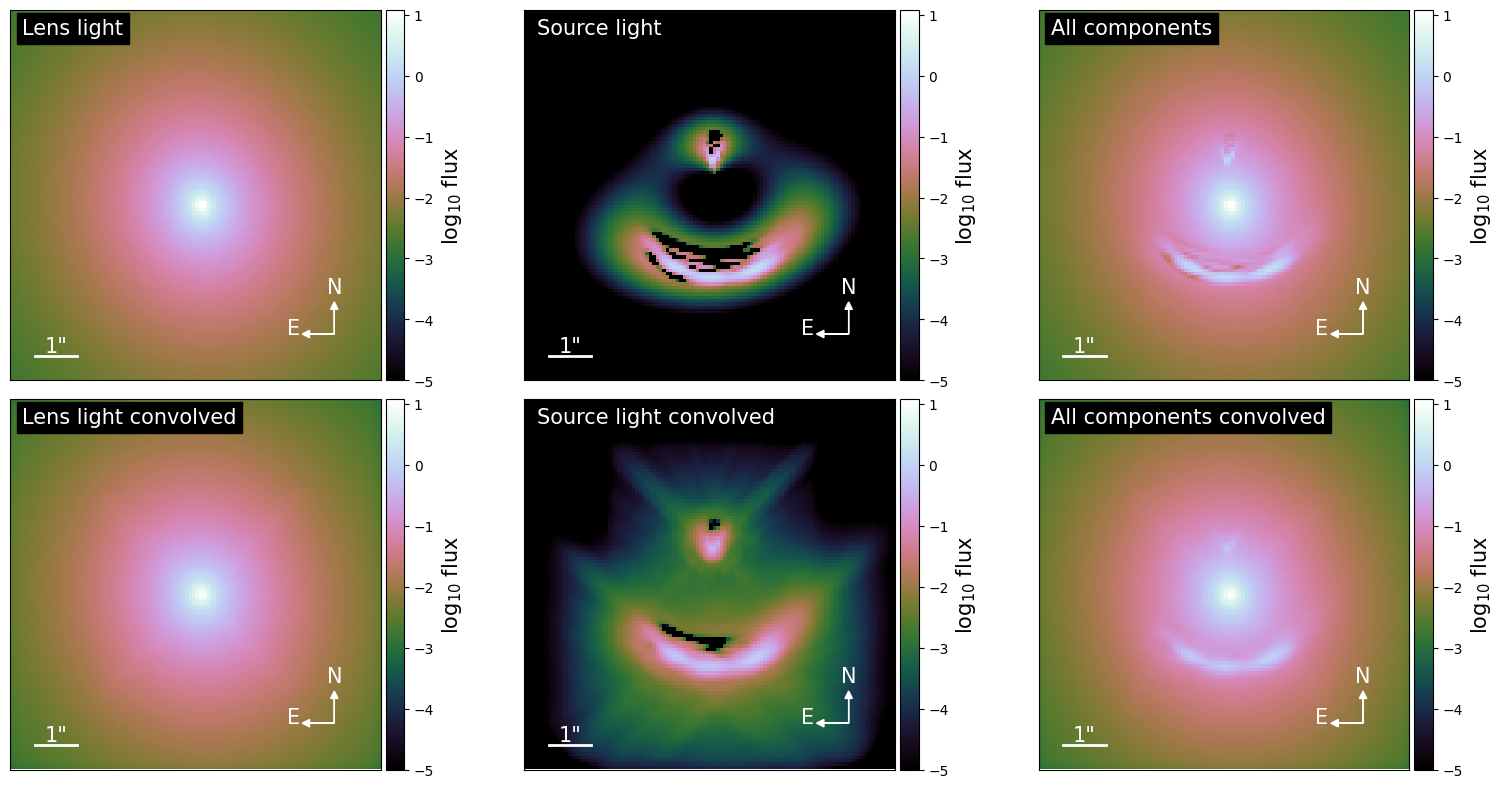

{'kwargs_lens': [{'theta_E': 1.5217772152251594, 'gamma': 2, 'e1': -0.07075222243538762, 'e2': 0.025879145615291192, 'center_x': -0.033244944003938445, 'center_y': 0.4356283245304627}, {'gamma1': 0.07825058289666453, 'gamma2': -0.006181185905329882, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 46.21496107935638, 'R_sersic': 0.19946554208599757, 'n_sersic': 1.0, 'e1': 0.17289171377711698, 'e2': -0.09959472352385644, 'center_x': -0.05697730405367622, 'center_y': -0.47195864859307646}, {'amp': array([-2.63565378e+02,  3.65979308e+01, -1.05652986e+02,  7.53422745e+01,
        2.61263551e-01,  1.37340086e+02,  1.76206275e+01, -1.24576801e+02,
       -3.45435054e+00, -1.50619012e+02,  1.20019835e+02,  1.92456283e+01,
        6.65857732e+01,  1.11565548e+01,  7.95922963e+01, -4.17080740e+01,
       -1.30418714e+02, -7.03739988e+01, -3.81537482e+01, -1.78471747e+01,
       -6.42140239e+01,  3.21523554e+01,  8.14617267e+01,  9.76761518e+01,
        8.37318036e+01, -2.32019065e+00,  3.1098

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])

model_plot.model_plot(ax=axes[0, 1])

model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")

model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.3
)

model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")

model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)

model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)

model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)

model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)

model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)

model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

plt.show()
print(kwargs_result)

## MCMC:

In [12]:
# Define the local path to save the backend file:

local_backend_path = "mcmc_backend3.h5"

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 1000,
            "n_walkers": 100,
            "sigma_scale": 0.1,
            "backend_filename": local_backend_path,
            "start_from_backend": True,
        },
    ],
]

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [14:31:07<00:00, 52.27s/it]


Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  0
Sampling iterations (in current run): 1000
52269.18204116821 time taken for MCMC sampling


## Trace plots of the resulting MCMC-run:

C:\Users\HTCM\AppData\Local\Temp\ipykernel_3380\1690565953.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 4030, N_walkers: 100, N_params: 19
theta_E_lens0 1.4854 ± 0.0127
gamma_lens0 2.3638 ± 0.1113
e1_lens0 -0.0653 ± 0.0066
e2_lens0 0.0319 ± 0.0129
center_x_lens0 -0.0936 ± 0.0117
center_y_lens0 0.0639 ± 0.1159
gamma1_lens1 0.1649 ± 0.0232
gamma2_lens1 -0.0389 ± 0.0187
R_sersic_source_light0 0.1948 ± 0.0070
e1_source_light0 0.0756 ± 0.0404
e2_source_light0 0.1345 ± 0.0743
center_x_source_light0 -0.2189 ± 0.0291
center_y_source_light0 -0.8822 ± 0.0951
beta_source_light1 0.0998 ± 0.0094
R_sersic_lens_light0 0.7190 ± 0.0042
e1_lens_light0 -0.0561 ± 0.0021
e2_lens_light0 0.0273 ± 0.0025
center_x_lens_light0 -0.0678 ± 0.0006
center_y_lens_light0 -0.3426 ± 0.0006


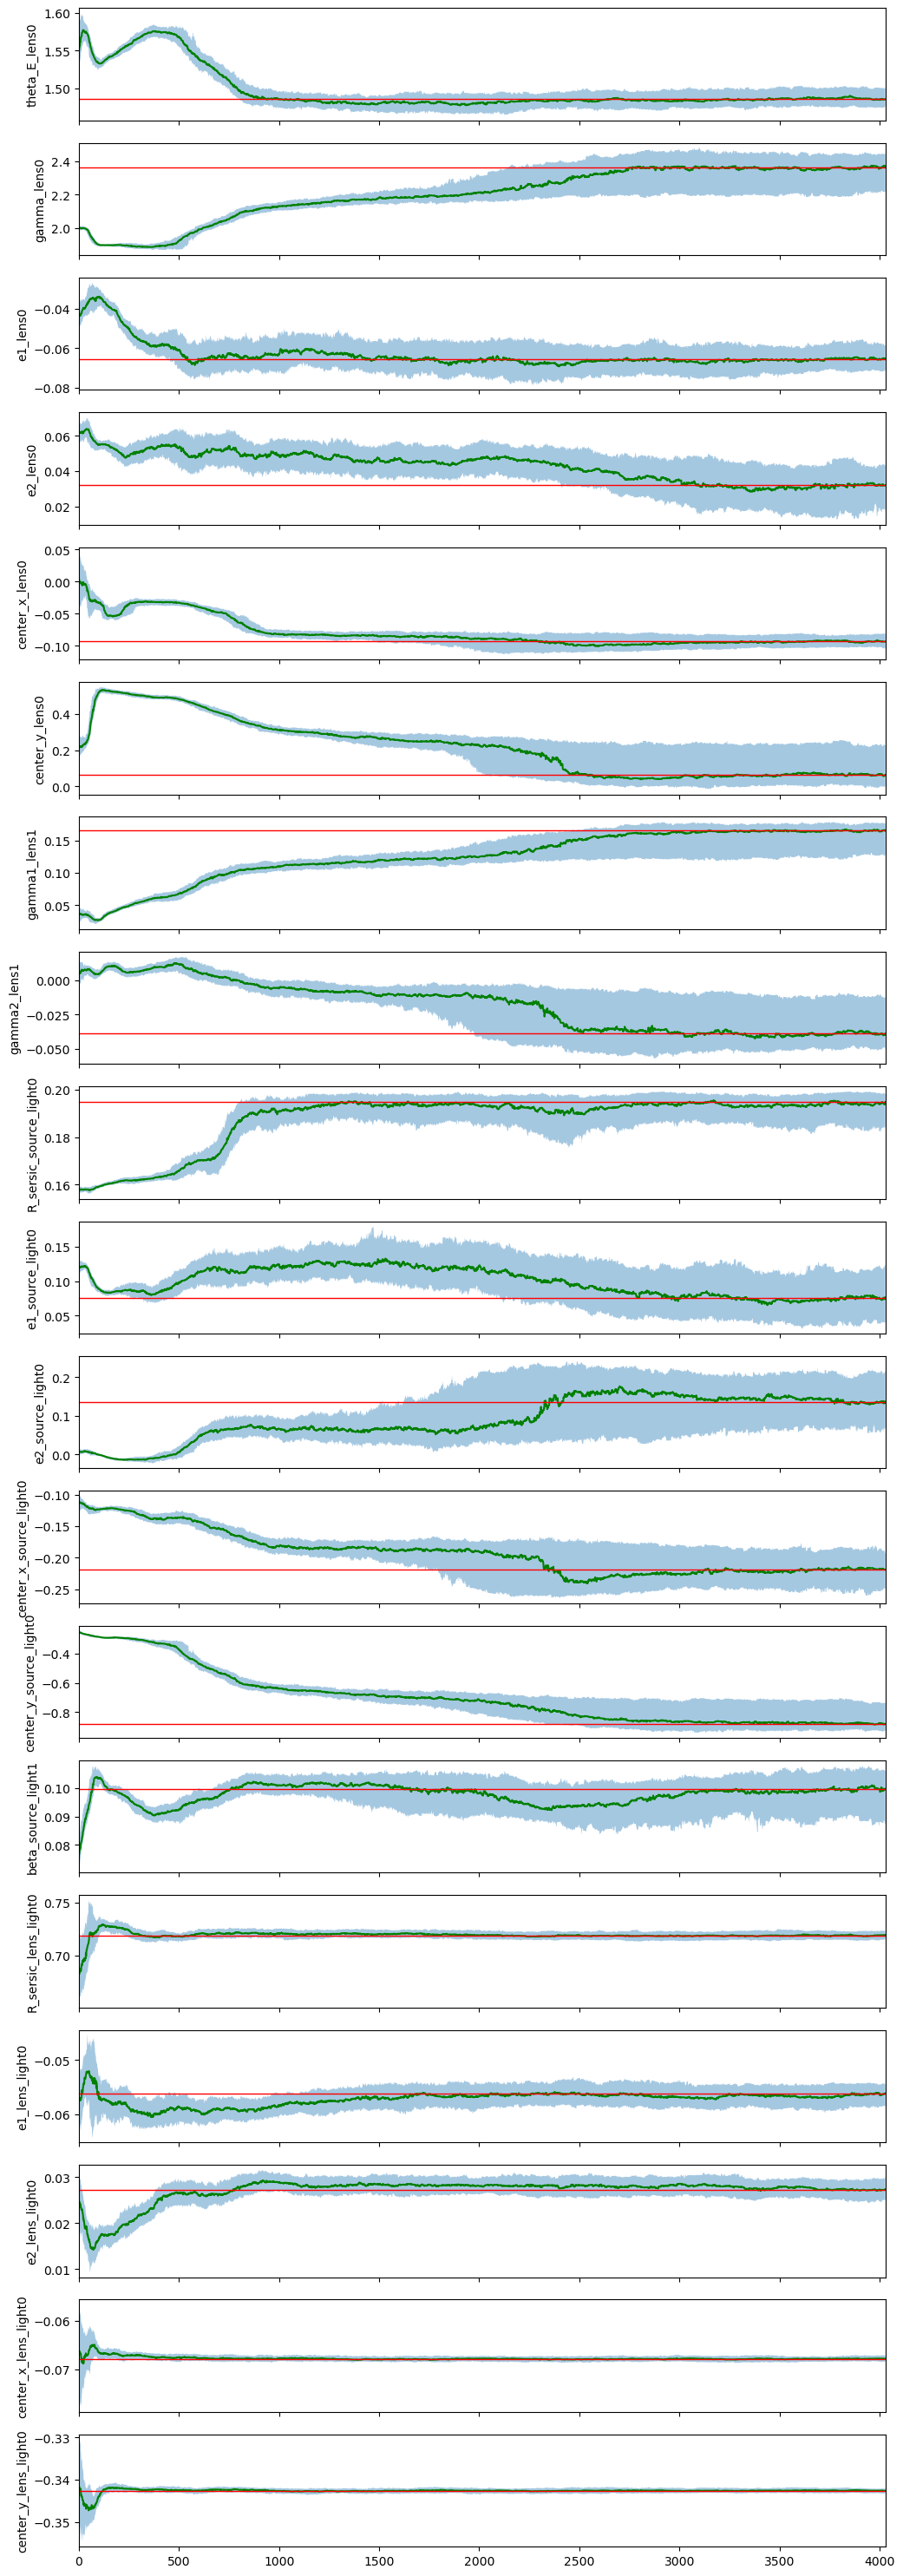

In [21]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]
    n_walkers = 100
    n_step = int(samples_mcmc.shape[0] / n_walkers)  # 2000
    n_burn = 0

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))
    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

## The corresponding corner plots:

Number of non-linear parameters in the MCMC process: 19
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
Number of evaluations in the MCMC process: 403000
403000


C:\Users\HTCM\AppData\Local\Temp\ipykernel_3380\1040690048.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


Shape of samples_mcmc_cut: (5000, 19)


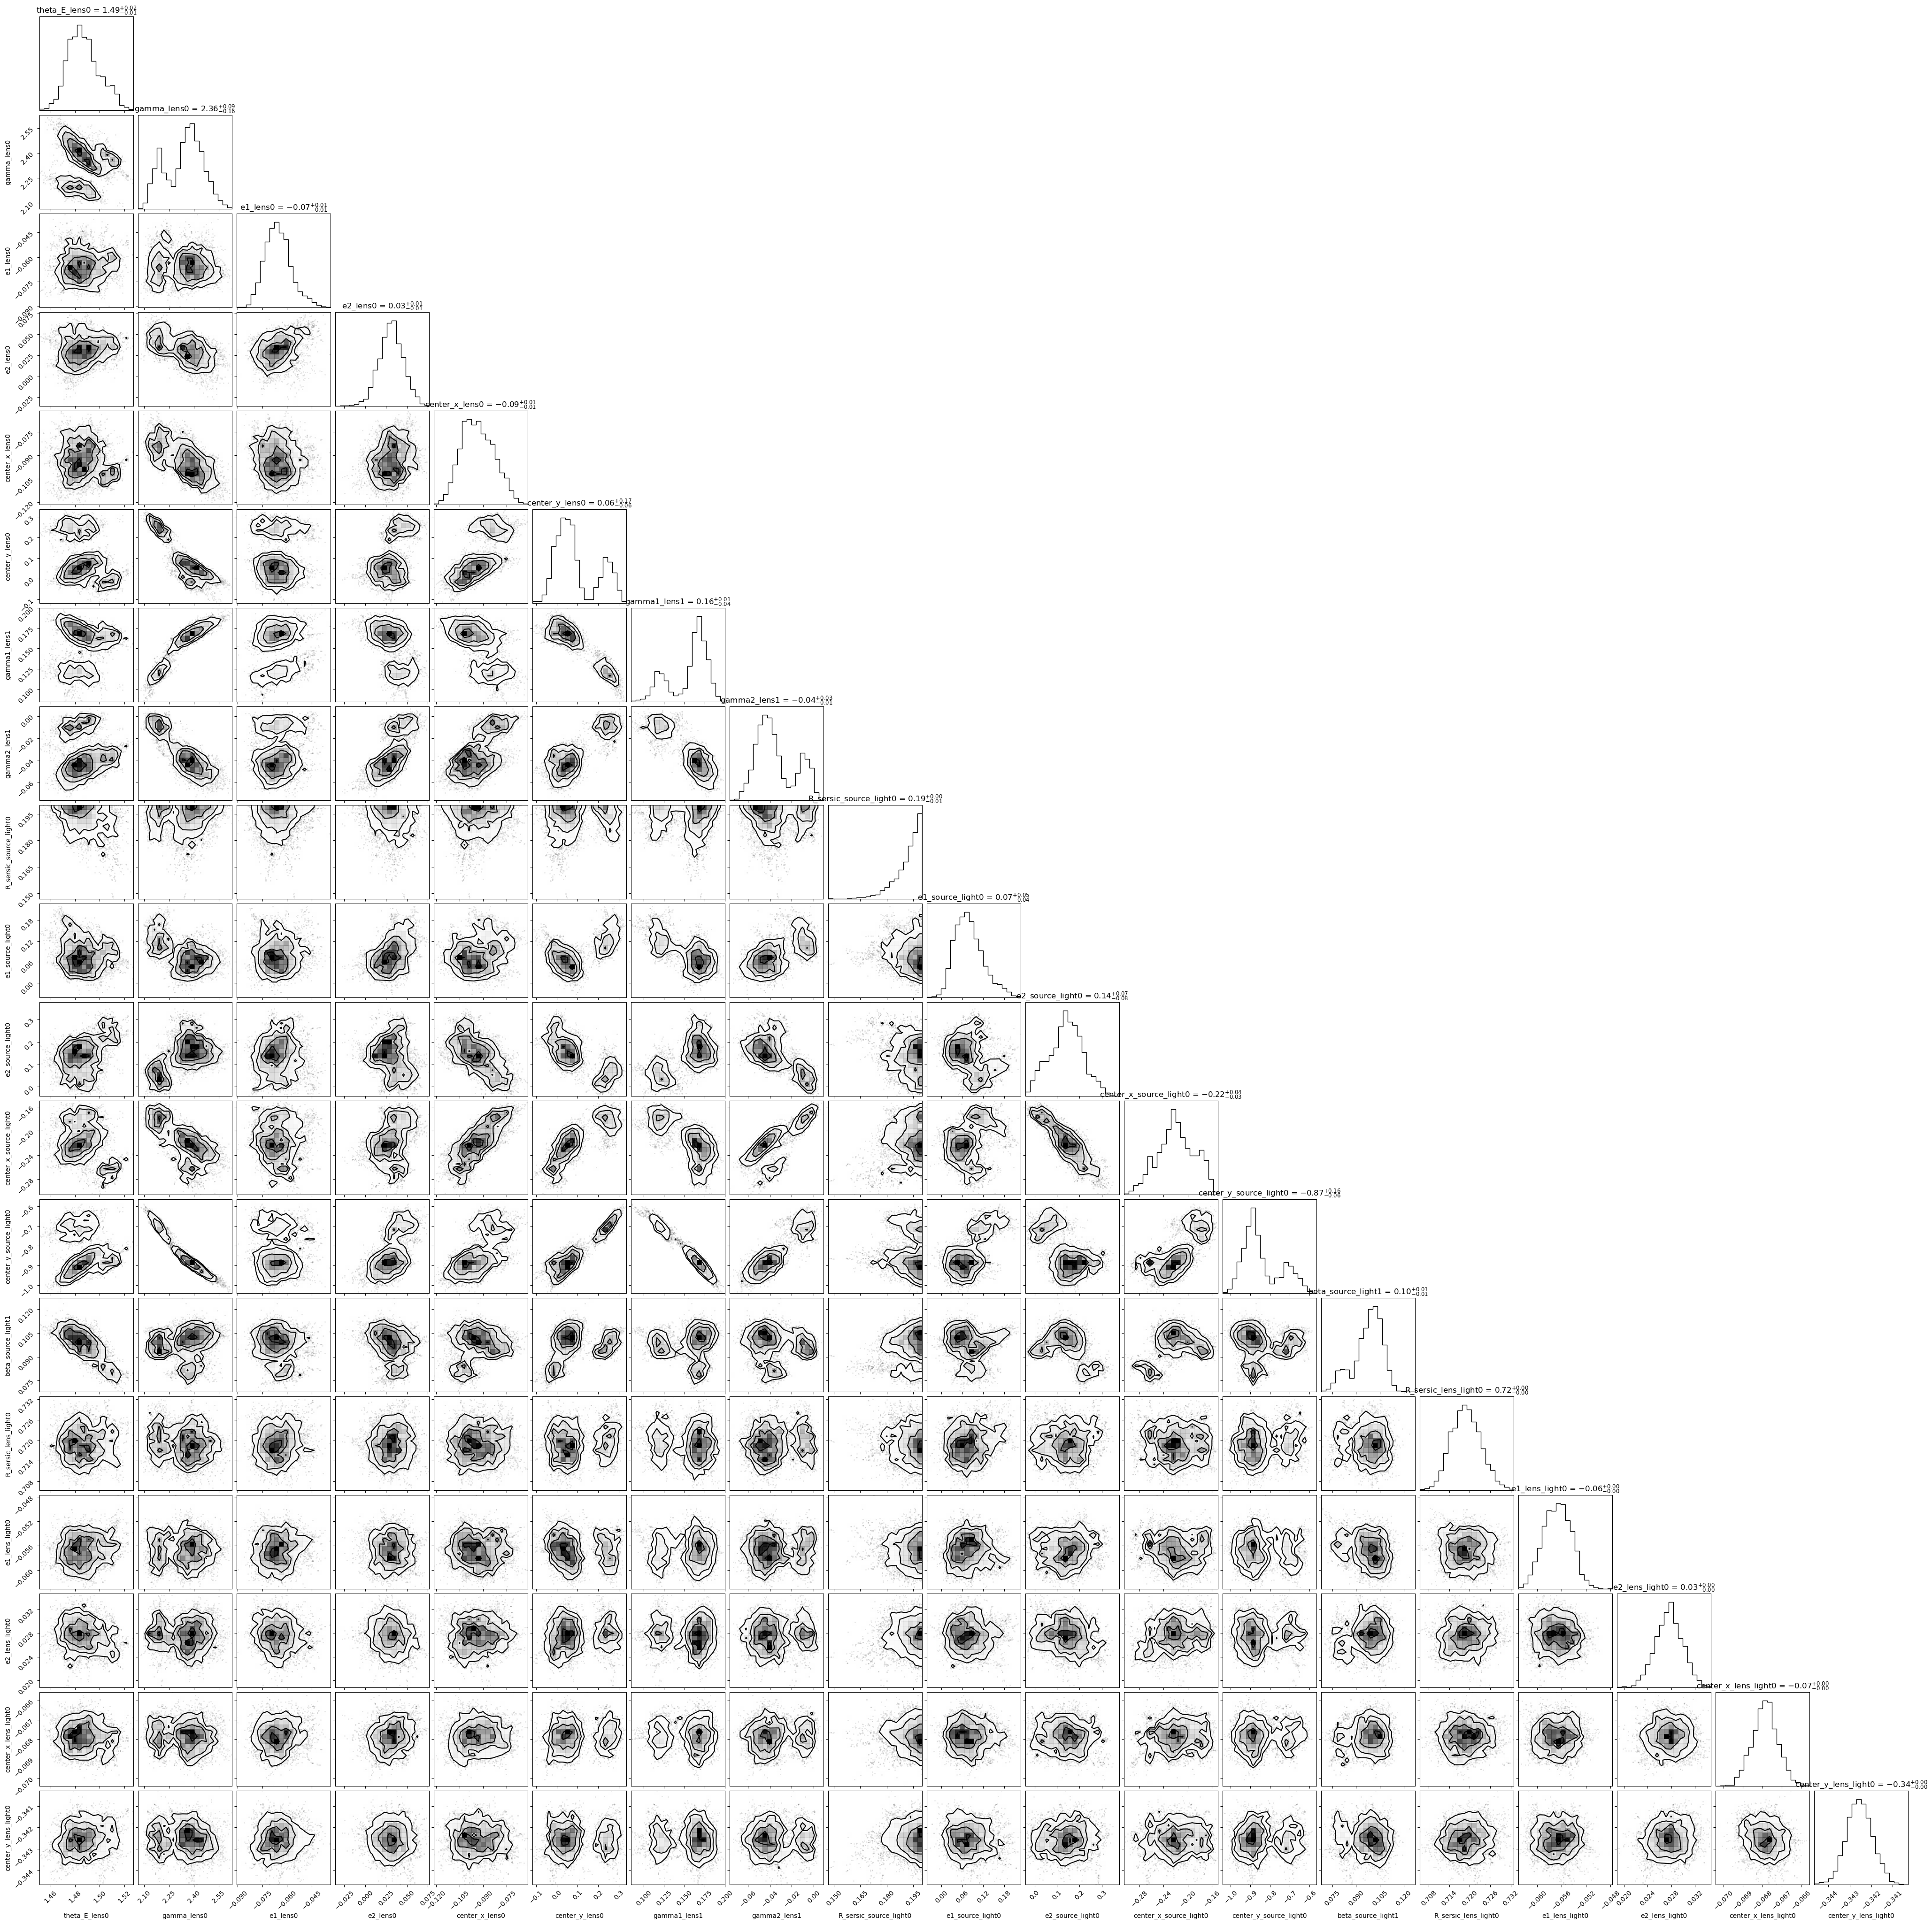

In [23]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 3030
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## Visualization of the MCMC fits:

-0.8962632532592667 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8962632532592689


C:\Users\HTCM\anaconda3\lib\site-packages\lenstronomy\Plots\model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
C:\Users\HTCM\anaconda3\lib\site-packages\lenstronomy\Plots\model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
C:\Users\HTCM\anaconda3\lib\site-packages\lenstronomy\Plots\model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


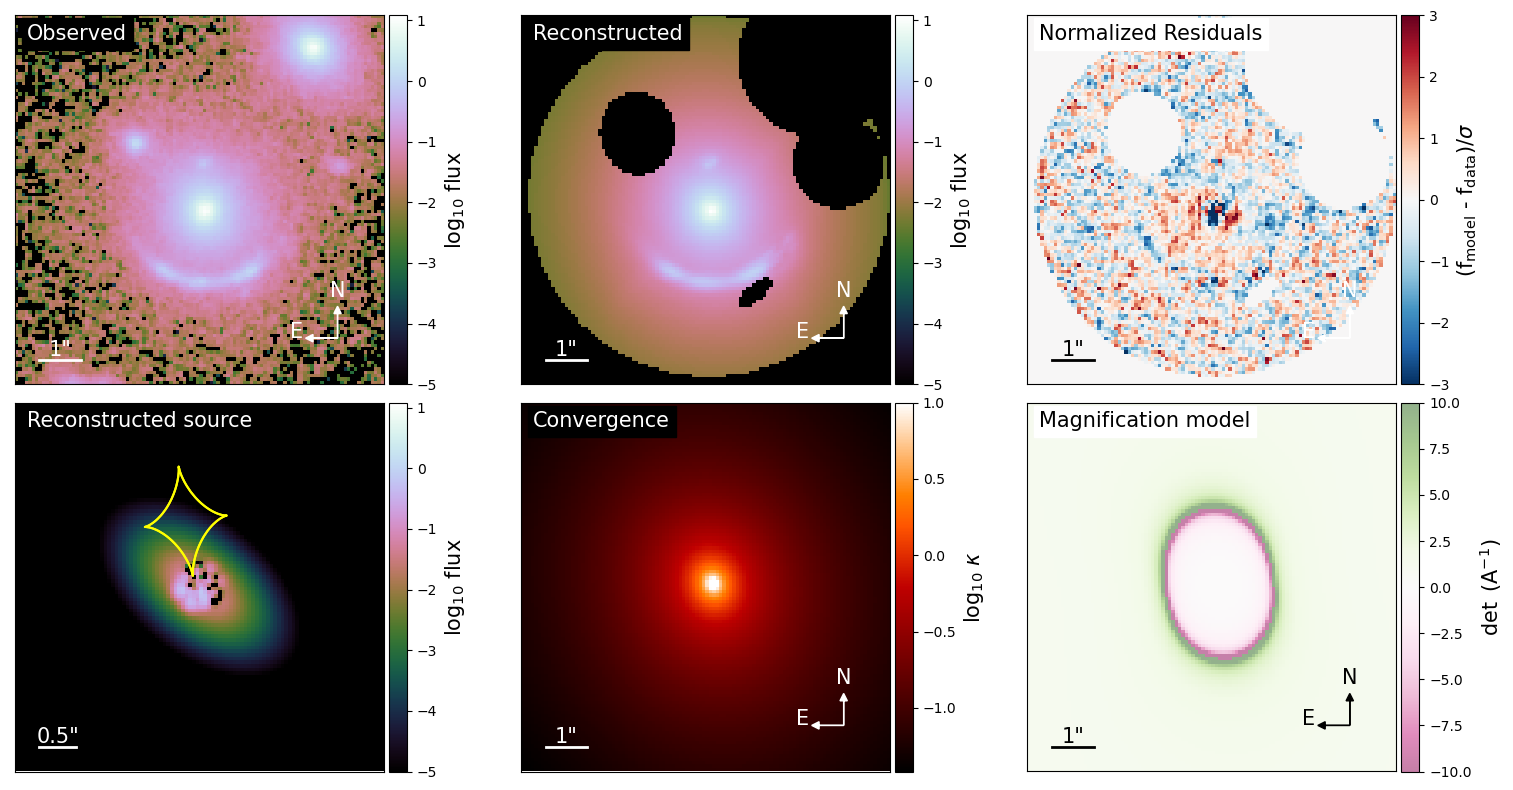

In [18]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

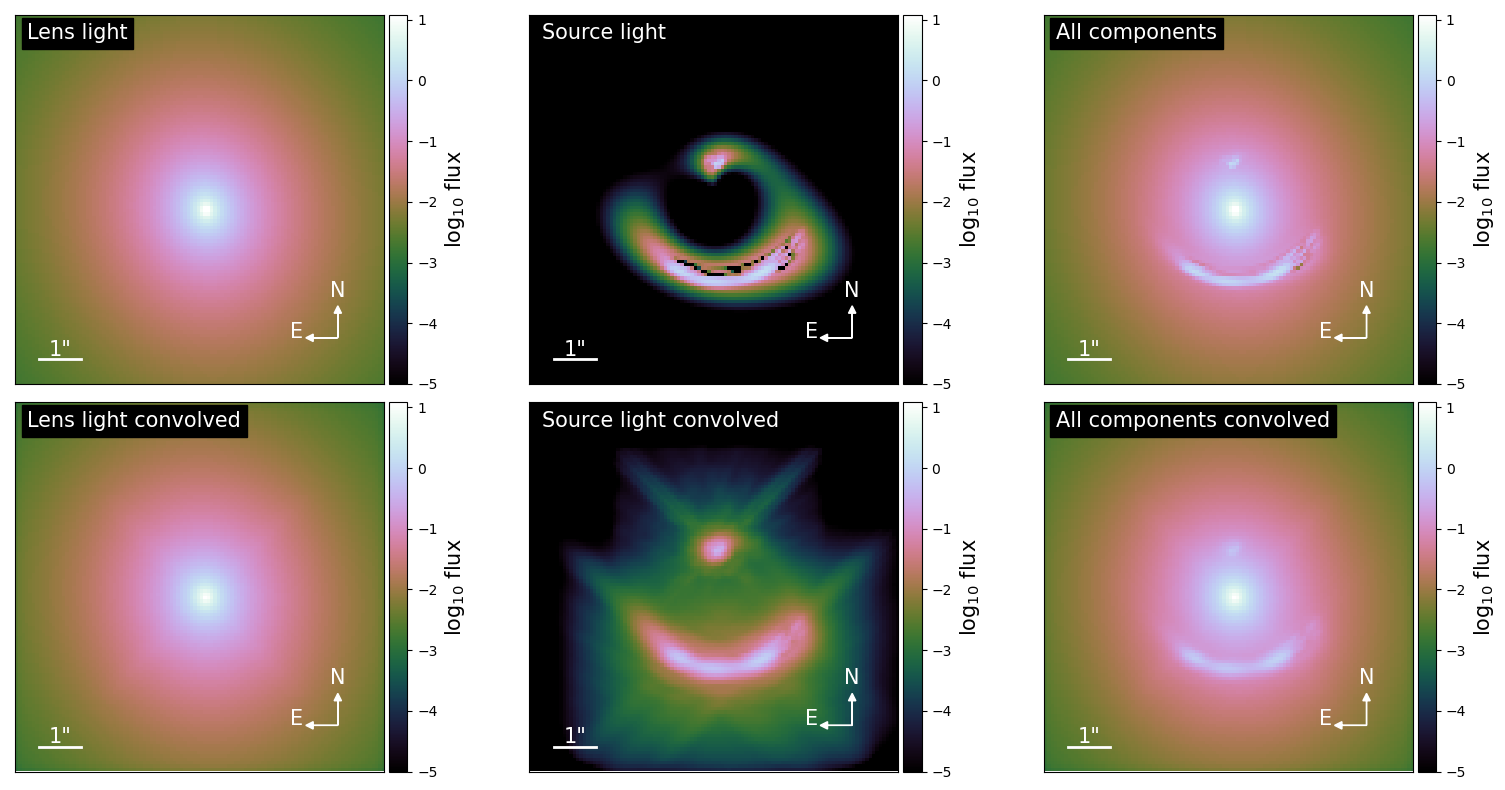

{'kwargs_lens': [{'theta_E': 1.5095118793567512, 'gamma': 2.394986592605777, 'e1': -0.06197152212253263, 'e2': 0.041907495559567694, 'center_x': -0.09957470508314237, 'center_y': -0.010252138130368566}, {'gamma1': 0.17559403697491957, 'gamma2': -0.03674807062529684, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 39.177307681463404, 'R_sersic': 0.18663008475889595, 'n_sersic': 1.0, 'e1': 0.06119361543164181, 'e2': 0.25760434429989776, 'center_x': -0.2651679790733356, 'center_y': -0.9086012096468155}, {'amp': array([-7.06843278e+01, -2.62453814e+01, -2.07611590e+02,  5.67771559e-02,
       -4.34013824e+01,  1.68741396e+02,  1.59804189e+02, -5.16717775e+01,
        3.89035187e+00, -1.15485952e+02,  1.06050854e+02, -1.20734517e+02,
        4.83591690e+01,  3.78545498e+00,  6.43567668e+01,  1.05956399e+02,
       -1.67468834e+01,  5.51486200e+01, -5.71370809e+01,  2.31852577e+01,
       -6.34247939e+01,  1.08849945e+02,  1.50436149e+01, -1.80278551e+00,
       -6.32109284e+01,  1.682574

In [19]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

In [20]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.8607920147635076,
light_q: 0.8831018902272045


## Saving the MCMC joblib file:

In [25]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

# Defining shortened_samples_mcmc
if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 3830
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)


output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]
output_path = "DESIJ1537+1443_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

Number of evaluations in the MCMC process: 403000
403000
Shape of shortened_samples_mcmc: (1000, 19)


## List of parameters to be included in the yaml file without conversion

In [26]:
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "R_sersic_lens_light0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}
print("\n", parameter_values)


 {'theta_E_lens0': [1.4867227430590084, 0.014475626414435894, 0.011868878609423428], 'gamma_lens0': [2.361037189993032, 0.0823343609128302, 0.1555675144087858], 'center_x_lens0': [-0.09355077123664048, 0.011189354800446874, 0.009108062069778267], 'center_y_lens0': [0.06516571705291144, 0.16501352212856668, 0.06474230452185357], 'R_sersic_lens_light0': [0.7188986354253777, 0.0042248301658541765, 0.004491418075416198], 'center_x_lens_light0': [-0.06780808263797557, 0.0006569299326263933, 0.0005917027272271669], 'center_y_lens_light0': [-0.34253359793071236, 0.0005197678624128677, 0.0005916515985776027]}


## Conversion

In [27]:
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "phi_shear",
    "gamma_shear",
    "phi_light",
    "q_light",
]
n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = param_util.ellipticity2phi_q(
                prior_samples[j][i], prior_samples[j][i + 1]
            )
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = param_util.shear_cartesian2polar(
                prior_samples[k][i], prior_samples[k][i + 1]
            )
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# merge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E_lens0': [1.4867227430590084, 0.014475626414435894, 0.011868878609423428], 'gamma_lens0': [2.361037189993032, 0.0823343609128302, 0.1555675144087858], 'center_x_lens0': [-0.09355077123664048, 0.011189354800446874, 0.009108062069778267], 'center_y_lens0': [0.06516571705291144, 0.16501352212856668, 0.06474230452185357], 'R_sersic_lens_light0': [0.7188986354253777, 0.0042248301658541765, 0.004491418075416198], 'center_x_lens_light0': [-0.06780808263797557, 0.0006569299326263933, 0.0005917027272271669], 'center_y_lens_light0': [-0.34253359793071236, 0.0005197678624128677, 0.0005916515985776027], 'phi_mass': [1.3325538613905072, 0.09377915374739354, 0.09420758821492403], 'q_mass': [0.8635068484850068, 0.010729078859957553, 0.010629186213093167], 'phi_shear': [-0.11326149798077778, 0.0691930788261142, 0.029887063109694273], 'gamma_shear': [0.17033331182023886, 0.0122857601103816, 0.04342086588184718], 'phi_light': [1.3457541153028705, 0.01886094367056934, 0.016684368747116318], 'q_l

## Half Light Radius Calculation

In [28]:
"""from light_profile import LightProfileAnalysis
from lenstronomy.LightModel.light_model import LightModel
light_model = LightModel(lens_light_model_list)
analysis = LightProfileAnalysis(light_model)

# Providing the lens light results from MCMC
kwargs_light = kwargs_result_mcmc["kwargs_lens_light"]

# Calculate the half-light radius
half_light_radius = analysis.half_light_radius(
    kwargs_light, grid_spacing=0.005, grid_num=10 / 0.005
)
print("Half-light radius:", half_light_radius)

# Adding to the dictionary
parameter_values["R_eff_light"] = half_light_radius"""

'from light_profile import LightProfileAnalysis\nfrom lenstronomy.LightModel.light_model import LightModel\nlight_model = LightModel(lens_light_model_list)\nanalysis = LightProfileAnalysis(light_model)\n\n# Providing the lens light results from MCMC\nkwargs_light = kwargs_result_mcmc["kwargs_lens_light"]\n\n# Calculate the half-light radius\nhalf_light_radius = analysis.half_light_radius(\n    kwargs_light, grid_spacing=0.005, grid_num=10 / 0.005\n)\nprint("Half-light radius:", half_light_radius)\n\n# Adding to the dictionary\nparameter_values["R_eff_light"] = half_light_radius'

In [29]:
# Mapping of old keys to new keys
key_mapping = {
    "theta_E_lens0": "theta_E",
    "gamma_lens0": "gamma",
    "R_sersic_lens_light0": "R_eff_light",
    "center_x_lens0": "center_x_mass",
    "center_y_lens0": "center_y_mass",
    "center_x_lens_light0": "center_x_light",
    "center_y_lens_light0": "center_y_light",
    "phi_mass": "phi_mass",
    "q_mass": "q_mass",
    "phi_shear": "phi_shear",
    "gamma_shear": "gamma_shear",
    "phi_light": "phi_light",
    "q_light": "q_light",
}

# Create a new dictionary with updated keys
parameter_values_new = {
    key_mapping.get(old_key, old_key): value
    for old_key, value in parameter_values.items()
}

print(parameter_values_new)

{'theta_E': [1.4867227430590084, 0.014475626414435894, 0.011868878609423428], 'gamma': [2.361037189993032, 0.0823343609128302, 0.1555675144087858], 'center_x_mass': [-0.09355077123664048, 0.011189354800446874, 0.009108062069778267], 'center_y_mass': [0.06516571705291144, 0.16501352212856668, 0.06474230452185357], 'R_eff_light': [0.7188986354253777, 0.0042248301658541765, 0.004491418075416198], 'center_x_light': [-0.06780808263797557, 0.0006569299326263933, 0.0005917027272271669], 'center_y_light': [-0.34253359793071236, 0.0005197678624128677, 0.0005916515985776027], 'phi_mass': [1.3325538613905072, 0.09377915374739354, 0.09420758821492403], 'q_mass': [0.8635068484850068, 0.010729078859957553, 0.010629186213093167], 'phi_shear': [-0.11326149798077778, 0.0691930788261142, 0.029887063109694273], 'gamma_shear': [0.17033331182023886, 0.0122857601103816, 0.04342086588184718], 'phi_light': [1.3457541153028705, 0.01886094367056934, 0.016684368747116318], 'q_light': [0.8822607653945832, 0.00371

## YAML file output

In [30]:
# make all the numpy variales to float
parameter_values_new = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values_new.items()
}
print(len(parameter_values_new))
# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1537+1443_point_estimates.yml"

with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values_new, yaml_file, default_flow_style=False)

print(f"YAML file '{yaml_file_name}' created successfully.")

13
YAML file 'DESIJ1537+1443_point_estimates.yml' created successfully.


In [31]:
# Read the YAML file using safe_load
with open(yaml_file_name, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': [0.7188986354253777, 0.0042248301658541765, 0.004491418075416198], 'Sigma_10': 0.03755252899460857, 'Sigma_10_flux_selected': 0.02182519937229172, 'Sigma_20': 0.036714136855385444, 'Sigma_20_flux_selected': 0.027278831394853535, 'center_x_light': [-0.06780808263797557, 0.0006569299326263933, 0.0005917027272271669], 'center_x_mass': [-0.09355077123664048, 0.011189354800446874, 0.009108062069778267], 'center_y_light': [-0.34253359793071236, 0.0005197678624128677, 0.0005916515985776027], 'center_y_mass': [0.06516571705291144, 0.16501352212856668, 0.06474230452185357], 'gamma': [2.361037189993032, 0.0823343609128302, 0.1555675144087858], 'gamma_shear': [0.17033331182023886, 0.0122857601103816, 0.04342086588184718], 'phi_light': [1.3457541153028705, 0.01886094367056934, 0.016684368747116318], 'phi_mass': [1.3325538613905072, 0.09377915374739354, 0.09420758821492403], 'phi_shear': [-0.11326149798077778, 0.0691930788261142, 0.029887063109694273]